<a href="https://colab.research.google.com/github/DebuggingaHopper/Drone/blob/main/Capitol_Drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The following Model conducts is binary label classification**



# You will notice that if I run the following the amount of labels are far more than the ones used in the datatset

In [ ]:
rectanglelabels_count = 0

for item in data:
    for completion in item.get("completions", []):
        for result in completion.get("result", []):
            if result.get("value", {}).get("rectanglelabels"):
                rectanglelabels_count += 1

print("Number of instances of rectanglelabels:", rectanglelabels_count)

Number of instances of rectanglelabels: 31


# **The following model is to the same but with a different approach to acquire the correct amount of labels present**

In [ ]:
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image

# Load JSON data
with open('result.json', 'r') as json_file:
    data = json.load(json_file)

# Prepare data
labels = []  # Bounding box coordinates
image_paths = []

for item in data:
    if "completions" in item and len(item["completions"]) > 0:
        completion = item["completions"][0]
        if "result" in completion and len(completion["result"]) > 0:
            for result in completion["result"]:
                if "value" in result and "rectanglelabels" in result["value"]:
                    for rectangle_label in result["value"]["rectanglelabels"]:
                        labels.append(result["value"]["rectanglelabels"])
                        image_path = item["data"]["image"]
                        image_path = image_path.split('-', 1)[-1]
                        image_paths.append(image_path)



# Load and preprocess images
images = []
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path).resize((341, 192))
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    images.append(img_array)
    print(image_path)
    print(f"Processed image {i + 1}/{len(image_paths)}")

# Now 'images' and 'labels' contain your image data and bounding box coordinates

DJI_0044.JPG
Processed image 1/31
DJI_0040.JPG
Processed image 2/31
DJI_0040.JPG
Processed image 3/31
DJI_0055.JPG
Processed image 4/31
DJI_0045.JPG
Processed image 5/31
DJI_0045.JPG
Processed image 6/31
DJI_0045.JPG
Processed image 7/31
DJI_0045.JPG
Processed image 8/31
DJI_0045.JPG
Processed image 9/31
DJI_0058.JPG
Processed image 10/31
DJI_0042.JPG
Processed image 11/31
DJI_0041.JPG
Processed image 12/31
DJI_0052.JPG
Processed image 13/31
DJI_0052.JPG
Processed image 14/31
DJI_0043.JPG
Processed image 15/31
DJI_0051.JPG
Processed image 16/31
DJI_0051.JPG
Processed image 17/31
DJI_0051.JPG
Processed image 18/31
DJI_0051.JPG
Processed image 19/31
DJI_0046.JPG
Processed image 20/31
DJI_0039.JPG
Processed image 21/31
DJI_0039.JPG
Processed image 22/31
DJI_0039.JPG
Processed image 23/31
DJI_0039.JPG
Processed image 24/31
DJI_0053.JPG
Processed image 25/31
DJI_0057.JPG
Processed image 26/31
DJI_0057.JPG
Processed image 27/31
DJI_0057.JPG
Processed image 28/31
DJI_0057.JPG
Processed image 

In [ ]:
print(len(labels))

31


In [ ]:
print(len(images))

31


In [ ]:
# Convert labels to one-hot encoding
label_set = list(set(label for sublist in labels for label in sublist))
label_to_index = {label: idx for idx, label in enumerate(label_set)}
num_classes = len(label_set)

# Convert labels to one-hot encoding
labels_encoded = []
for label_list in labels:
    label_encoded = [0] * num_classes
    for label in label_list:
        label_encoded[label_to_index[label]] = 1
    labels_encoded.append(label_encoded)

# Convert lists to NumPy arrays
images_array = np.array(images)
labels_array = np.array(labels_encoded)



In [ ]:
# Define and compile the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(192, 341, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(num_classes, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(images_array, labels_array, epochs=10, batch_size=32)













Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6911 - accuracy: 0.3548
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 3.0452 - accuracy: 0.6452
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 2.2062 - accuracy: 0.6452
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1.4313 - accuracy: 0.7097
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.9776 - accuracy: 0.6774
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.7487 - accuracy: 0.5806
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.5199 - accuracy: 0.7419
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.3172 - accuracy: 0.9355
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.3396 - accuracy: 0.9355
Epoch 10/10
1/1 [==============================] - 1s 1s/step - loss: 0.3726 - accuracy: 0.9032


In [ ]:

# Choose a random index from the training dataset
random_index = np.random.randint(0, len(images_array))

# Load and preprocess the random image
random_image = images_array[random_index]
random_image = np.expand_dims(random_image, axis=0)  # Add batch dimension

# Get the actual labels for the random image
actual_labels = labels_array[random_index]

# Run prediction
predictions = model.predict(random_image)

# Threshold predictions (you can adjust the threshold based on your needs)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.int)

# Print or use the predictions as needed
print("Actual Labels:", actual_labels)
print("Predictions:", binary_predictions)

# Calculate accuracy
accuracy = np.mean(np.equal(actual_labels, binary_predictions))
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 65ms/step
Actual Labels: [0 1 0]
Predictions: [[0 1 0]]
Accuracy: 1.0


<ipython-input-74-85b04643d66f>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary_predictions = (predictions > threshold).astype(np.int)


# Bounding Box Visualizer V1

In [ ]:

import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image, ImageDraw

# Load JSON data
with open('result.json', 'r') as json_file:
    data = json.load(json_file)

# Prepare data
labels = []  # Bounding box coordinates
bounding_boxes = []  # Added to store bounding box coordinates
image_paths = []

for item in data:
    if "completions" in item and len(item["completions"]) > 0:
        completion = item["completions"][0]
        if "result" in completion and len(completion["result"]) > 0:
            for result in completion["result"]:
                if "value" in result and "rectanglelabels" in result["value"]:
                    for rectangle_label in result["value"]["rectanglelabels"]:
                        labels.append(result["value"]["rectanglelabels"])

                        # get the box coordinates
                        width =result["value"]["width"]
                        x = result["value"]["x"]
                        y = result["value"]["y"]

                        # Use the extracted values as needed (e.g., constructing bounding boxes on images)
                        print("width:", width)
                        print("x:", x)
                        print("y:", y)

                        # If you want to store the bounding box coordinates, you can append them to a list
                        bounding_boxes.append({"width": width, "x": x, "y": y})


                        image_path = item["data"]["image"]
                        image_path = image_path.split('-', 1)[-1]
                        image_paths.append(image_path)

# Load and preprocess images
images = []
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path).resize((341, 192))
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    images.append(img_array)
    print(image_path)
    print(f"Processed image {i + 1}/{len(image_paths)}")

# Convert labels to one-hot encoding
label_set = list(set(label for sublist in labels for label in sublist))
label_to_index = {label: idx for idx, label in enumerate(label_set)}
num_classes = len(label_set)

# Convert labels to one-hot encoding
labels_encoded = []
for label_list in labels:
    label_encoded = [0] * num_classes
    for label in label_list:
        label_encoded[label_to_index[label]] = 1
    labels_encoded.append(label_encoded)

# Convert bounding boxes to numpy array
#bounding_boxes_array = np.array(bounding_boxes)
bounding_boxes_array = np.array([[box["width"], box["x"], box["y"]] for box in bounding_boxes])

# Convert lists to NumPy arrays
images_array = np.array(images)
labels_array = np.array(labels_encoded)










width: 14.08668013689587
x: 31.46736651928088
y: 0.15666169319406925
width: 5.309159302636927
x: 20.647262557166922
y: 82.63390454321399
width: 3.066666666666667
x: 41.6
y: 93.60189573459715
width: 8.262641705207106
x: 92.42867924912171
y: 96.12954186413903
width: 39.08985434601146
x: 6.747562777320545
y: 58.26572840841153
width: 5.333333333333333
x: 94.53333333333333
y: 68.24644549763033
width: 7.066666666666666
x: 86.56966216562428
y: 29.812825334253937
width: 4
x: 89.6
y: 0.47393364928909953
width: 2.4
x: 97.2
y: 45.023696682464454
width: 24.70174057275522
x: -8.706989399591238
y: 50.200605588632044
width: 3.8666666666666667
x: 95.86666666666666
y: 15.876777251184834
width: 15.466666666666667
x: 56.4
y: 66.1845334512055
width: 6.445714480860705
x: 22.53714286129491
y: 80.33175283133701
width: 1.7333333333333334
x: 44
y: 95.260663507109
width: 8.43409855743575
x: 91.74295082300739
y: 94.16199913830246
width: 2.6666666666666665
x: 58.53333333333333
y: 88.62559241706161
width: 2.666666

In [ ]:
print(len(bounding_boxes_array))

31


In [ ]:

# Load MobileNetV2 as a backbone
base_model = keras.applications.MobileNetV2(
    input_shape=(192, 341, 3), include_top=False, weights='imagenet'
)

# Freeze the layers of the base model
base_model.trainable = False

# Create a custom head for bounding box regression
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='linear')  # 3 units for (width, x, y)
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

'''
# Define and compile the model with named output layers
class_output = layers.Dense(num_classes, activation='sigmoid', name='class_output')
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(192, 341, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    class_output,  # For class probabilities
    bbox_output  # For bounding box coordinates (x, y, width, height)
])

# Compile the model with separate losses for each output
model.compile(optimizer='adam', loss={'class_output': 'binary_crossentropy', 'bbox_output': 'mse'}, metrics=['accuracy'])

# Train the model
model.fit(images_array, {'class_output': labels_array, 'bbox_output': bounding_boxes_array}, epochs=10, batch_size=32)



# Make predictions
predictions = model.predict(images_array)

# Extract bounding box predictions
bounding_box_predictions = predictions[1]

# Assuming your bounding box predictions have the format [x, y, width, height]
for i, bounding_box in enumerate(bounding_box_predictions):
    x, y, width, height = bounding_box

    # Denormalize coordinates
    x *= 341
    y *= 192
    width *= 341
    height *= 192

    # Construct bounding box
    box = {
        "x": x,
        "y": y,
        "width": width,
        "height": height
    }

    # Draw bounding box on the original image
    original_img = Image.open(image_paths[i])
    draw = ImageDraw.Draw(original_img)
    draw.rectangle([box["x"], box["y"], box["x"] + box["width"], box["y"] + box["height"]], outline="red", width=2)
    original_img.show()
'''

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 6, 11, 1280)       2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 128)               163968    
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 3)                 195       
                                                                 
Total params: 2430403 (9.27 MB)
Trainable params: 1724

'\n# Define and compile the model with named output layers\nclass_output = layers.Dense(num_classes, activation=\'sigmoid\', name=\'class_output\')\nbbox_output = layers.Dense(4, activation=\'sigmoid\', name=\'bbox_output\')\n\nmodel = keras.Sequential([\n    layers.Conv2D(32, (3, 3), activation=\'relu\', input_shape=(192, 341, 3)),\n    layers.MaxPooling2D((2, 2)),\n    layers.Flatten(),\n    class_output,  # For class probabilities\n    bbox_output  # For bounding box coordinates (x, y, width, height)\n])\n\n# Compile the model with separate losses for each output\nmodel.compile(optimizer=\'adam\', loss={\'class_output\': \'binary_crossentropy\', \'bbox_output\': \'mse\'}, metrics=[\'accuracy\'])\n\n# Train the model\nmodel.fit(images_array, {\'class_output\': labels_array, \'bbox_output\': bounding_boxes_array}, epochs=10, batch_size=32)\n\n\n\n# Make predictions\npredictions = model.predict(images_array)\n\n# Extract bounding box predictions\nbounding_box_predictions = predictions[

In [ ]:

model.fit(
    images_array, bounding_boxes_array,
    epochs=10, batch_size=32, validation_split=0.2
)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 2697.4817 - accuracy: 0.2500 - val_loss: 2613.5630 - val_accuracy: 0.7143
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2572.7437 - accuracy: 0.7083 - val_loss: 2528.5183 - val_accuracy: 0.5714
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 2458.5757 - accuracy: 0.6667 - val_loss: 2415.8735 - val_accuracy: 0.5714
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 2331.3748 - accuracy: 0.6250 - val_loss: 2291.7251 - val_accuracy: 0.7143
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 2190.7002 - accuracy: 0.5833 - val_loss: 2160.0920 - val_accuracy: 0.7143
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 2041.1989 - accuracy: 0.6667 - val_loss: 2024.1174 - val_accuracy: 0.7143
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 1886.1615 - accuracy: 0.6667 - val_loss: 1883.0242 - val_accuracy: 0.7143

In [ ]:
import random
# Randomly select an index from the training data
random_index = random.randint(0, len(images_array) - 1)

# Get the randomly selected image
random_image = images_array[random_index]

# Make a prediction using the model
prediction = model.predict(np.array([random_image]))

# Extract predicted bounding box coordinates
predicted_width, predicted_x, predicted_y = prediction[0]

# Print or use the predicted values as needed
print("Predicted width:", predicted_width)
print("Predicted x:", predicted_x)
print("Predicted y:", predicted_y)



1/1 [==============================] - 1s 1s/step
Predicted width: 4.9423265
Predicted x: 27.66161
Predicted y: 27.003887


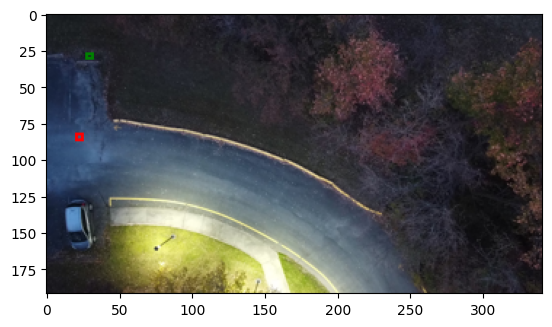

In [ ]:
# Visualize the prediction on the randomly selected image
import matplotlib.pyplot as plt

# Assuming 'image_paths' contains the paths to your training images
random_image_path = image_paths[random_index]
img = Image.open(random_image_path).resize((341, 192))

# Draw the ground truth bounding box in red
draw = ImageDraw.Draw(img)
ground_truth_box = bounding_boxes[random_index]
draw.rectangle([ground_truth_box["x"], ground_truth_box["y"],
                ground_truth_box["x"] + ground_truth_box["width"],
                ground_truth_box["y"] + ground_truth_box["width"]], outline="red", width=2)

# Draw the predicted bounding box in green
draw.rectangle([predicted_x, predicted_y,
                predicted_x + predicted_width,
                predicted_y + predicted_width], outline="green", width=2)

# Display the image with bounding boxes
plt.imshow(img)
plt.show()

# **Bounding Box Visualizer V 2**

In [ ]:

import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image, ImageDraw

# Load JSON data
with open('result.json', 'r') as json_file:
    data = json.load(json_file)

# Prepare data
labels = []  # Bounding box coordinates
bounding_boxes = []  # Added to store bounding box coordinates
image_paths = []

for item in data:
    if "completions" in item and len(item["completions"]) > 0:
        completion = item["completions"][0]
        if "result" in completion and len(completion["result"]) > 0:
            for result in completion["result"]:
                if "value" in result and "rectanglelabels" in result["value"]:
                    for rectangle_label in result["value"]["rectanglelabels"]:
                        labels.append(result["value"]["rectanglelabels"])

                        # get the box coordinates

                        height = result["value"]["height"]
                        width =result["value"]["width"]
                        x = result["value"]["x"]
                        y = result["value"]["y"]
                        rotation = result["value"]["rotation"]

                        # Use the extracted values as needed (e.g., constructing bounding boxes on images)

                        print("height", height)
                        print("width:", width)
                        print("x:", x)
                        print("y:", y)
                        print("rotation:", rotation)

                        # If you want to store the bounding box coordinates, you can append them to a list
                        bounding_boxes.append({"height" : height,"width": width, "x": x, "y": y,"rotation": rotation})


                        image_path = item["data"]["image"]
                        image_path = image_path.split('-', 1)[-1]
                        image_paths.append(image_path)

# Load and preprocess images
images = []
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path).resize((341, 192))
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    images.append(img_array)
    print(image_path)
    print(f"Processed image {i + 1}/{len(image_paths)}")

# Convert labels to one-hot encoding
label_set = list(set(label for sublist in labels for label in sublist))
label_to_index = {label: idx for idx, label in enumerate(label_set)}
num_classes = len(label_set)

# Convert labels to one-hot encoding
labels_encoded = []
for label_list in labels:
    label_encoded = [0] * num_classes
    for label in label_list:
        label_encoded[label_to_index[label]] = 1
    labels_encoded.append(label_encoded)

# Convert bounding boxes to numpy array
#bounding_boxes_array = np.array(bounding_boxes)
bounding_boxes_array = np.array([[box["height"],box["width"], box["x"], box["y"],box["rotation"]] for box in bounding_boxes])

# Convert lists to NumPy arrays
images_array = np.array(images)
labels_array = np.array(labels_encoded)










height 7.964444554821036
width: 14.08668013689587
x: 31.46736651928088
y: 0.15666169319406925
rotation: 344.24283146947425
height 6.632450862546141
width: 5.309159302636927
x: 20.647262557166922
y: 82.63390454321399
rotation: 326.30310979618173
height 5.924170616113744
width: 3.066666666666667
x: 41.6
y: 93.60189573459715
rotation: 0
height 6.319115323854661
width: 8.262641705207106
x: 92.42867924912171
y: 96.12954186413903
rotation: 0
height 41.47215691246828
width: 39.08985434601146
x: 6.747562777320545
y: 58.26572840841153
rotation: 340.2386242615462
height 3.5545023696682465
width: 5.333333333333333
x: 94.53333333333333
y: 68.24644549763033
rotation: 0
height 5.687203791469194
width: 7.066666666666666
x: 86.56966216562428
y: 29.812825334253937
rotation: 347.9190027613653
height 3.3175355450236967
width: 4
x: 89.6
y: 0.47393364928909953
rotation: 0
height 0.9478672985781991
width: 2.4
x: 97.2
y: 45.023696682464454
rotation: 0
height 45.05739312135387
width: 24.70174057275522
x: -8.7

In [ ]:
print(bounding_boxes_array.shape)

(31, 5)


In [94]:

'''
# Load MobileNetV2 as a backbone
base_model = keras.applications.MobileNetV2(
    input_shape=(192, 341, 3), include_top=False, weights='imagenet'
)

# Freeze the layers of the base model
base_model.trainable = False

# Create a custom head for bounding box regression
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='linear')  # 5 units for (height, width, x, y, rotation)
])


# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',  # or custom MSE loss if needed
    metrics=['accuracy']
)
# Display the model summary
model.summary()
'''

import tensorflow as tf
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_array, bounding_boxes_array, test_size=0.2, random_state=42)

# Define a simple regression model (replace this with your chosen architecture)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(192, 341, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='linear')  # 5 units for (height, width, x, y, rotation)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model



In [95]:

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
#model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 8428.2373 - accuracy: 0.0833 - val_loss: 4624.7295 - val_accuracy: 0.1429
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 6275.7759 - accuracy: 0.2917 - val_loss: 5881.7656 - val_accuracy: 0.1429
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 5392.5054 - accuracy: 0.2917 - val_loss: 5671.2495 - val_accuracy: 0.1429
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 4653.9839 - accuracy: 0.2917 - val_loss: 5057.4072 - val_accuracy: 0.4286
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 4411.7632 - accuracy: 0.4167 - val_loss: 5030.2681 - val_accuracy: 0.4286
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 4556.4771 - accuracy: 0.5000 - val_loss: 5029.7368 - val_accuracy: 0.4286
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 4228.7065 - accuracy: 0.5000 - val_loss: 5148.1748 - val_accuracy: 0.4286

In [96]:
def draw_rotated_rectangle(image, x, y, width, height, rotation, color=(0, 255, 0), thickness=2):
    angle_rad = math.radians(rotation)
    cos_val = math.cos(angle_rad)
    sin_val = math.sin(angle_rad)

    # Calculate rotated corner coordinates
    x1 = int(x - width / 2)
    y1 = int(y - height / 2)
    x2 = int(x + width / 2)
    y2 = int(y - height / 2)
    x3 = int(x + width / 2)
    y3 = int(y + height / 2)
    x4 = int(x - width / 2)
    y4 = int(y + height / 2)

    # Rotate the corners
    x1_rot = int(x + cos_val * (x1 - x) - sin_val * (y1 - y))
    y1_rot = int(y + sin_val * (x1 - x) + cos_val * (y1 - y))
    x2_rot = int(x + cos_val * (x2 - x) - sin_val * (y2 - y))
    y2_rot = int(y + sin_val * (x2 - x) + cos_val * (y2 - y))
    x3_rot = int(x + cos_val * (x3 - x) - sin_val * (y3 - y))
    y3_rot = int(y + sin_val * (x3 - x) + cos_val * (y3 - y))
    x4_rot = int(x + cos_val * (x4 - x) - sin_val * (y4 - y))
    y4_rot = int(y + sin_val * (x4 - x) + cos_val * (y4 - y))

    # Draw the rotated rectangle
    points = np.array([[x1_rot, y1_rot], [x2_rot, y2_rot], [x3_rot, y3_rot], [x4_rot, y4_rot]], np.int32)
    points = points.reshape((-1, 1, 2))
    image = cv2.polylines(image, [points], isClosed=True, color=color, thickness=thickness)

    return image


In [101]:
import random
# Randomly select an index from the training data
random_index = random.randint(0, len(images_array) - 1)

# Get the randomly selected image
random_image = images_array[random_index]

# Make a prediction using the model
prediction = model.predict(np.array([random_image]))

# Extract predicted bounding box coordinates
predicted_height,predicted_width, predicted_x, predicted_y,predicted_rotation = prediction[0]

# Print or use the predicted values as needed
print("Predicted height:", predicted_height)
print("Predicted width:", predicted_width)
print("Predicted x:", predicted_x)
print("Predicted y:", predicted_y)
print("Predicted rotation:", predicted_rotation)




1/1 [==============================] - 0s 111ms/step
Predicted height: 5.2604933
Predicted width: 14.906328
Predicted x: 22.419525
Predicted y: 63.645454
Predicted rotation: 44.804405


1/1 [==============================] - 0s 86ms/step


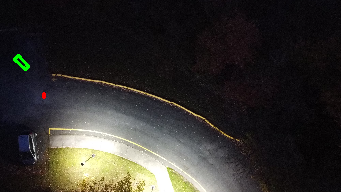

In [103]:
# Display the image with bounding boxes
from google.colab.patches import cv2_imshow

# Assuming 'image_paths' contains the paths to your training images
random_image_path = image_paths[random_index]
img = cv2.imread(random_image_path)
img = cv2.resize(img, (341, 192))

# Draw the ground truth bounding box in red
ground_truth_box = bounding_boxes[random_index]
draw_rotated_rectangle(img, ground_truth_box["x"], ground_truth_box["y"], ground_truth_box["width"], ground_truth_box["height"], ground_truth_box["rotation"], color=(0, 0, 255), thickness=2)

# Assuming 'predicted_values' contains the predicted values for height, width, x, y, and rotation
predicted_values = model.predict(images_array[random_index:random_index + 1])

# Extracting values from the predicted values
predicted_height, predicted_width, predicted_x, predicted_y, predicted_rotation = predicted_values[0]

# Draw the predicted bounding box in green
draw_rotated_rectangle(img, predicted_x, predicted_y, predicted_width, predicted_height, predicted_rotation, color=(0, 255, 0), thickness=2)

# Display the image with bounding boxes
cv2_imshow(img)


# **Model V3**

In [130]:

import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image, ImageDraw

# Load JSON data
with open('result.json', 'r') as json_file:
    data = json.load(json_file)

# Prepare data
labels = []  # Bounding box coordinates
bounding_boxes = []  # Added to store bounding box coordinates
image_paths = []

for item in data:
    if "completions" in item and len(item["completions"]) > 0:
        completion = item["completions"][0]
        if "result" in completion and len(completion["result"]) > 0:
            for result in completion["result"]:
                if "value" in result and "rectanglelabels" in result["value"]:
                    for rectangle_label in result["value"]["rectanglelabels"]:
                        labels.append(result["value"]["rectanglelabels"])

                        # get the box coordinates

                        height = result["value"]["height"]
                        width =result["value"]["width"]
                        x = result["value"]["x"]
                        y = result["value"]["y"]
                        rotation = result["value"]["rotation"]

                        # Use the extracted values as needed (e.g., constructing bounding boxes on images)

                        print("height", height)
                        print("width:", width)
                        print("x:", x)
                        print("y:", y)
                        print("rotation:", rotation)

                        # If you want to store the bounding box coordinates, you can append them to a list
                        bounding_boxes.append({"height" : height,"width": width, "x": x, "y": y,"rotation": rotation})


                        image_path = item["data"]["image"]
                        image_path = image_path.split('-', 1)[-1]
                        image_paths.append(image_path)

# Load and preprocess images
images = []
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path).resize((341, 192))
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    images.append(img_array)
    print(image_path)
    print(f"Processed image {i + 1}/{len(image_paths)}")

# Convert labels to one-hot encoding
label_set = list(set(label for sublist in labels for label in sublist))
label_to_index = {label: idx for idx, label in enumerate(label_set)}
num_classes = len(label_set)

# Convert labels to one-hot encoding
labels_encoded = []
for label_list in labels:
    label_encoded = [0] * num_classes
    for label in label_list:
        label_encoded[label_to_index[label]] = 1
    labels_encoded.append(label_encoded)

# Convert bounding boxes to numpy array
#bounding_boxes_array = np.array(bounding_boxes)
bounding_boxes_array = np.array([[box["height"],box["width"], box["x"], box["y"],box["rotation"]] for box in bounding_boxes])

# Convert lists to NumPy arrays
images_array = np.array(images)
labels_array = np.array(labels_encoded)

height 7.964444554821036
width: 14.08668013689587
x: 31.46736651928088
y: 0.15666169319406925
rotation: 344.24283146947425
height 6.632450862546141
width: 5.309159302636927
x: 20.647262557166922
y: 82.63390454321399
rotation: 326.30310979618173
height 5.924170616113744
width: 3.066666666666667
x: 41.6
y: 93.60189573459715
rotation: 0
height 6.319115323854661
width: 8.262641705207106
x: 92.42867924912171
y: 96.12954186413903
rotation: 0
height 41.47215691246828
width: 39.08985434601146
x: 6.747562777320545
y: 58.26572840841153
rotation: 340.2386242615462
height 3.5545023696682465
width: 5.333333333333333
x: 94.53333333333333
y: 68.24644549763033
rotation: 0
height 5.687203791469194
width: 7.066666666666666
x: 86.56966216562428
y: 29.812825334253937
rotation: 347.9190027613653
height 3.3175355450236967
width: 4
x: 89.6
y: 0.47393364928909953
rotation: 0
height 0.9478672985781991
width: 2.4
x: 97.2
y: 45.023696682464454
rotation: 0
height 45.05739312135387
width: 24.70174057275522
x: -8.7

In [131]:
print(labels_array)

[[0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]]


In [138]:
print(label_set)

['boat', 'Lampost', 'Fhouse']


In [132]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from PIL import Image

# Define the model
def create_object_detection_model(num_classes):
    # Input layer
    input_layer = layers.Input(shape=(192, 341, 3), name='input_image')

    # Convolutional layers for feature extraction
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and dense layers for classification
    x_classification = layers.Flatten()(x)
    x_classification = layers.Dense(128, activation='relu')(x_classification)
    output_classification = layers.Dense(num_classes, activation='softmax', name='output_classification')(x_classification)

    # Dense layers for bounding box regression
    x_regression = layers.Flatten()(x)
    x_regression = layers.Dense(128, activation='relu')(x_regression)
    output_regression = layers.Dense(5, activation='linear', name='output_regression')(x_regression)  # 5 units for (height, width, x, y, rotation)

    # Create the model
    model = models.Model(inputs=input_layer, outputs=[output_classification, output_regression])

    return model

# Create and compile the model
num_classes = len(label_set)
model = create_object_detection_model(num_classes)
model.compile(optimizer='adam',
              loss={'output_classification': 'categorical_crossentropy', 'output_regression': 'mean_squared_error'},
              metrics={'output_classification': 'accuracy'})

# Train the model
model.fit(images_array, {'output_classification': labels_array, 'output_regression': bounding_boxes_array},
          epochs=3, batch_size=32, validation_split=0.2)


Epoch 1/3
1/1 [==============================] - 6s 6s/step - loss: 7463.8384 - output_classification_loss: 1.0837 - output_regression_loss: 7462.7554 - output_classification_accuracy: 0.6667 - val_loss: 7635.4185 - val_output_classification_loss: 6.4914 - val_output_regression_loss: 7628.9272 - val_output_classification_accuracy: 0.5714
Epoch 2/3
1/1 [==============================] - 4s 4s/step - loss: 6765.9199 - output_classification_loss: 6.2051 - output_regression_loss: 6759.7148 - output_classification_accuracy: 0.6667 - val_loss: 6418.4214 - val_output_classification_loss: 3.5342 - val_output_regression_loss: 6414.8872 - val_output_classification_accuracy: 0.5714
Epoch 3/3
1/1 [==============================] - 6s 6s/step - loss: 5584.9468 - output_classification_loss: 3.1520 - output_regression_loss: 5581.7944 - output_classification_accuracy: 0.6667 - val_loss: 5344.5181 - val_output_classification_loss: 8.8648 - val_output_regression_loss: 5335.6528 - val_output_classificati

1/1 [==============================] - 0s 439ms/step


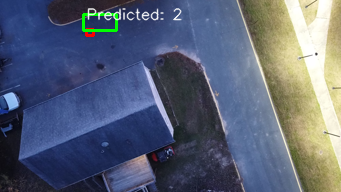

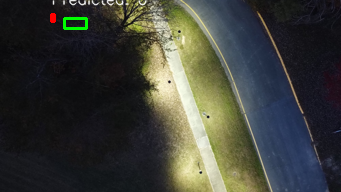

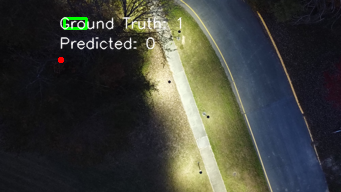

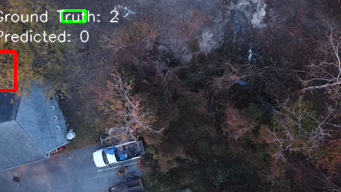

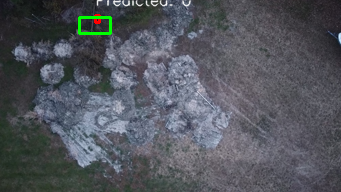

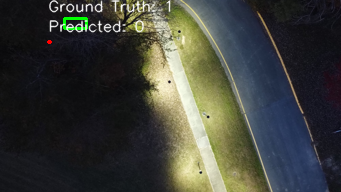

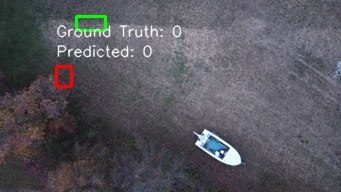

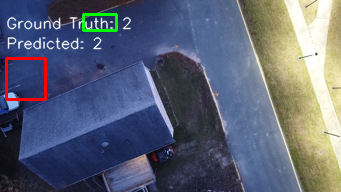

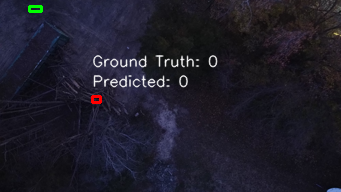

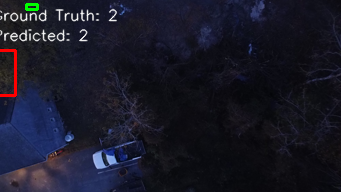

In [137]:
from google.colab.patches import cv2_imshow
import numpy as np

# Randomly select indices for testing
num_images = len(images_array)
test_indices = np.random.choice(num_images, size=10, replace=False)

# Extract test images, ground truth bounding boxes, and class labels
test_images = images_array[test_indices]
ground_truth_boxes = bounding_boxes_array[test_indices]

# Perform predictions
predictions = model.predict(test_images)

# Assuming labels_array is one-hot encoded
actual_class_indices = np.argmax(labels_array, axis=1)

# Create a list of unique class labels
class_labels = list(set(actual_class_indices))

# Visualize the predictions with OpenCV in Colab
for i in range(len(test_indices)):
    # Assuming 'test_indices' contains the indices of your testing images
    random_index = test_indices[i]

    # Extract ground truth values
    gt_height, gt_width, gt_x, gt_y, gt_rotation = ground_truth_boxes[i]

    # Extract predicted values
    predicted_height, predicted_width, predicted_x, predicted_y, predicted_rotation = predictions[1][i]  # Assuming regression output is at index 1

    # Extract the predicted class index
    predicted_class_index = np.argmax(predictions[0][i])  # Assuming classification output is at index 0

    # Get the predicted class label
    predicted_class_label = class_labels[predicted_class_index]
    gt_class_label = class_labels[actual_class_indices[random_index]]

    # Create an image copy to draw on
    img = (test_images[i] * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Draw the ground truth bounding box in red
    cv2.rectangle(img, (int(gt_x), int(gt_y)), (int(gt_x + gt_width), int(gt_y + gt_height)), (0, 0, 255), 2)

    # Draw the predicted bounding box in green
    cv2.rectangle(img, (int(predicted_x), int(predicted_y)), (int(predicted_x + predicted_width), int(predicted_y + predicted_height)), (0, 255, 0), 2)


    # Display the predicted class label
    cv2.putText(img, f'Predicted: {predicted_class_label}', (int(gt_x), int(gt_y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(img, f'Ground Truth: {gt_class_label}', (int(gt_x), int(gt_y) - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    # Display the image with bounding boxes using cv2_imshow
    cv2_imshow(img)


1/1 [==============================] - 1s 589ms/step


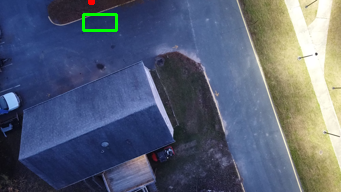

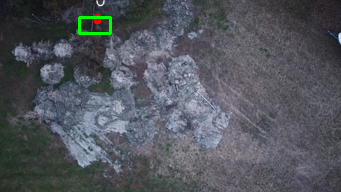

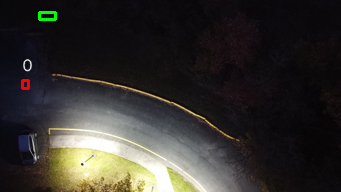

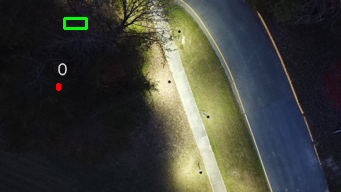

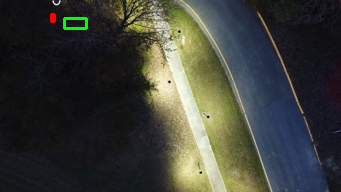

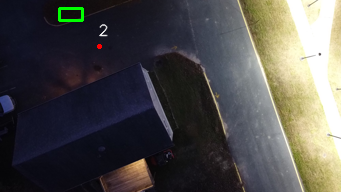

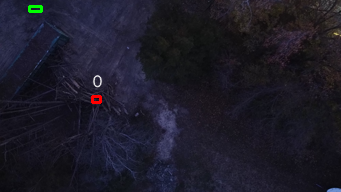

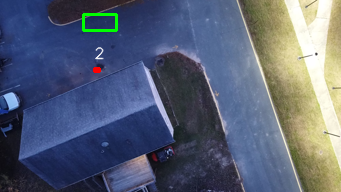

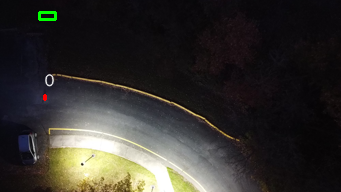

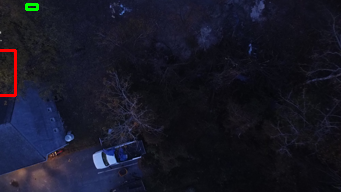

In [143]:
with open('results.txt', 'w') as results_file:
    # Randomly select indices for testing
    num_images = len(images_array)
    test_indices = np.random.choice(num_images, size=10, replace=False)

    # Extract test images, ground truth bounding boxes, and class labels
    test_images = images_array[test_indices]
    ground_truth_boxes = bounding_boxes_array[test_indices]

    # Perform predictions
    predictions = model.predict(test_images)

    # Assuming labels_array is one-hot encoded
    actual_class_indices = np.argmax(labels_array, axis=1)

    # Create a list of unique class labels
    class_labels = list(set(actual_class_indices))

    # Visualize the predictions with OpenCV in Colab
    for i in range(len(test_indices)):
        # Assuming 'test_indices' contains the indices of your testing images
        random_index = test_indices[i]

        # Extract ground truth values
        gt_height, gt_width, gt_x, gt_y, gt_rotation = ground_truth_boxes[i]

        # Extract predicted values
        predicted_height, predicted_width, predicted_x, predicted_y, predicted_rotation = predictions[1][i]  # Assuming regression output is at index 1

        # Extract the predicted class index
        predicted_class_index = np.argmax(predictions[0][i])  # Assuming classification output is at index 0

        # Get the predicted class label
        predicted_class_label = class_labels[predicted_class_index]
        gt_class_label = class_labels[actual_class_indices[random_index]]

        # Create an image copy to draw on
        img = (test_images[i] * 255).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Draw the ground truth bounding box in red
        cv2.rectangle(img, (int(gt_x), int(gt_y)), (int(gt_x + gt_width), int(gt_y + gt_height)), (0, 0, 255), 2)

        # Draw the predicted bounding box in green
        cv2.rectangle(img, (int(predicted_x), int(predicted_y)), (int(predicted_x + predicted_width), int(predicted_y + predicted_height)), (0, 255, 0), 2)

        # Display the predicted class label
        cv2.putText(img, str(predicted_class_label), (int(gt_x), int(gt_y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        # Display the image with bounding boxes using cv2_imshow
        cv2_imshow(img)

        # Write the results to the text file
        results_file.write(f"Image {random_index}:\n")
        results_file.write(f"Predicted Class: {predicted_class_label}\n")
        results_file.write(f"Ground Truth Class: {gt_class_label}\n")
        results_file.write(f"Predicted Bounding Box: {predicted_x}, {predicted_y}, {predicted_width}, {predicted_height}\n")
        results_file.write(f"Ground Truth Bounding Box: {gt_x}, {gt_y}, {gt_width}, {gt_height}\n\n")

# **Model v4**